In [50]:
from model.Model import Model
import os
from model.Model import Model
from preprocess.preprocess import Dataset, PreprocessFrame
import numpy as np
import seaborn; sns.set()
import matplotlib.pyplot as plt
from collections import Counter

In [17]:
# images size
img_width = 600
img_height = 100

new_img_width = 300
new_img_height = 50

batch_size = 16

# default paths
WORKING_DIR = os.path.join('/home', 'mts')
ann_path = os.path.join(WORKING_DIR, 'HKR_Dataset_Words_Public', 'ann')
img_path = os.path.join(WORKING_DIR, 'HKR_Dataset_Words_Public', 'img')
metadata = os.path.join(WORKING_DIR, 'metadata', 'metadata.tsv')

In [18]:
params = {
    'callbacks': ['checkpoint', 'csv_log', 'tb_log', 'early_stopping'],
    'metrics': ['cer', 'accuracy'],
    'checkpoint_path': os.path.join(WORKING_DIR, 'checkpoints/training_0/cp.ckpt'),
    'csv_log_path': os.path.join(WORKING_DIR, 'logs/csv_logs/log_0.csv'),
    'tb_log_path': os.path.join(WORKING_DIR, 'logs/tb_logs/log0'),
    'tb_update_freq': 200,
    'epochs': 50,
    'batch_size': batch_size,
    'restore_weights': True,
    'early_stopping_patience': 10,
    'input_img_shape': (new_img_width, new_img_height, 1),
    'vocab_len': 75,
    'max_label_len': 22,
    'chars_path': os.path.join(os.path.split(metadata)[0], 'symbols.txt'),
    'blank': '#',
    'blank_index': 74
}

model = Model(params)
model.build()
model.load_weights('checkpoints/training_0/cp.ckpt')
print(model.pred_model)

None


In [8]:
# collect metadata
# meta_collect(ann_path, metadata)

# get preprocessed metadata dataframe
df = PreprocessFrame(metadata=metadata,
                     img_height=img_height, img_width=img_width)

# Make augments file (if they exists: comment or delete line)
aug_df = None
aug_df = make_augments(df=df, img_path=img_path, WORKING_DIR=WORKING_DIR,
                        img_height=img_height, img_width=img_width)

# get augments metadata dataframe from original dataframe if not starting make_augments
if not isinstance(aug_df, pd.DataFrame):
    aug_df = df.copy()
    aug_df.index = aug_df.index.to_series().apply(lambda x: os.path.join('aug_1', 'aug_' + x))

_, test, _ = list(Dataset(df, aug_df=aug_df,
                                test_size=0.1,
                                val_size=0.05,
                                img_path=img_path,
                                img_height=img_height,
                                img_width=img_width,
                                new_img_height=new_img_height,
                                new_img_width=new_img_width,
                                WORKING_DIR=WORKING_DIR,
                                shuffle=True,
                                random_state=12))
test

100%|██████████| 97/97 [04:14<00:00,  2.63s/it]


<PrefetchDataset shapes: {image: (None, 300, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>

In [19]:
def show_preds_on_batch(model, batch, batch_size=batch_size):
    _, ax = plt.subplots(batch_size, 1, figsize=(10, 50))

    batch_images = batch['image']
    batch_labels = batch['label']

    pred_texts = model.predict(batch)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(model.num_to_char(label)).numpy().decode('utf-8').replace('#', '')
        orig_texts.append(label)
    for i in range(batch_size):
        img = ((batch_images[i, :, :, 0] + 0.5) * 255).numpy().astype('uint8')
        img = img.T
        title = f"Prediction: {pred_texts[i]}\nOriginal: {orig_texts[i]}"
        ax[i].set_title(title)
        ax[i].imshow(img, cmap="gray")

In [38]:
y_pred = np.empty((0, ))
y_true = np.empty((0, ))
for batch in test:
    y_pred = np.append(y_pred, model.predict(batch))
    for label in batch['label']:
        label = tf.strings.reduce_join(model.num_to_char(label)).numpy().decode('utf-8').replace('#', '')
        y_true = np.append(y_true, label)
y_comp = np.stack((y_pred, y_true), axis=-1)
y_comp

array([['изалечилараны,', 'изалечилараны,'],
       ['Сергеевкк', 'Сергеевка'],
       ['Огнем', 'Огнем'],
       ...,
       ['УЗБЕКИСТАН', 'УЗБЕКИСТАН'],
       ['встаетс', 'встаетс'],
       ['Киргизия', 'Киргизия']], dtype='<U32')

In [46]:
vec_len = np.vectorize(len)
confusions = y_comp[(y_pred != y_true) & (vec_len(y_pred) == vec_len(y_true))]
confusions

array([['Сергеевкк', 'Сергеевка'],
       ['покоитсяпрах.', 'покоитсяпрах:'],
       ['хлодный', 'хладный'],
       ...,
       ['Наикоголь,', 'Наихогонь,'],
       ['Стрена', 'Страна'],
       ['мирныйтроктор,', 'мирныйтрактор,']], dtype='<U32')

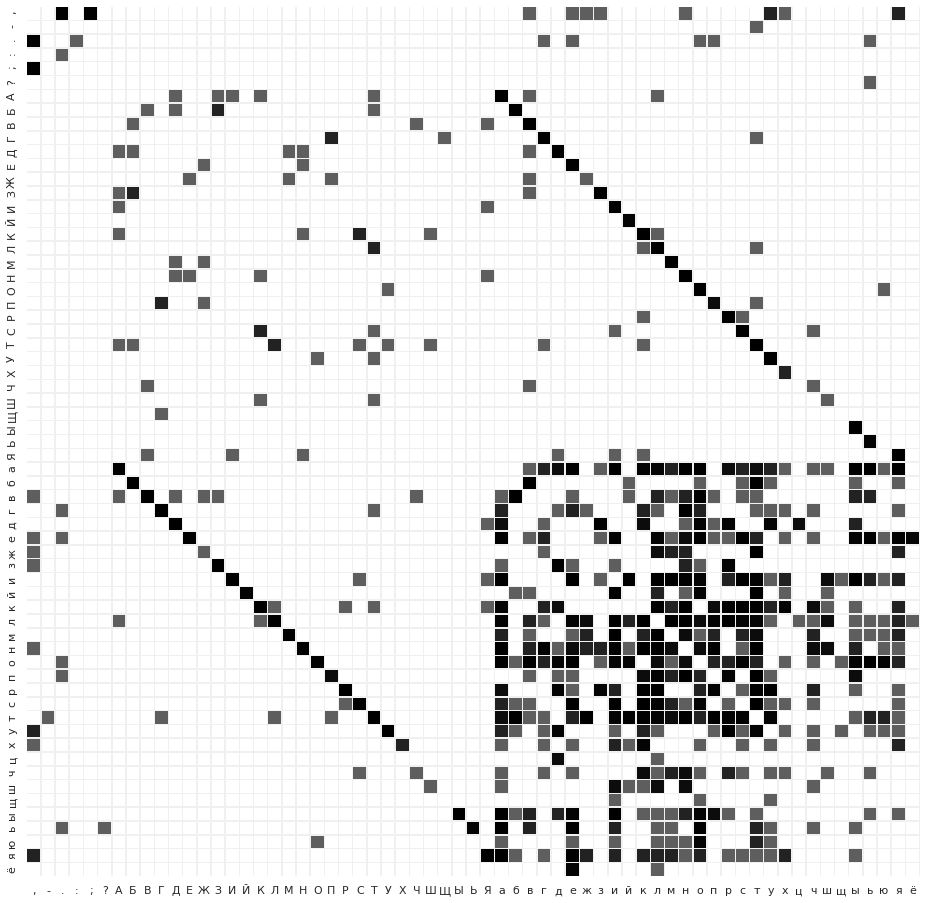

In [91]:
alphabet = set()
for pr, tr in confusions:
    for c1, c2 in zip(pr, tr):
        if c1 != c2:
            alphabet.add(c1)
            alphabet.add(c2)
alphabet = sorted(alphabet)
char_to_i = {c: i for i, c in enumerate(alphabet)}
conf_matrix = np.zeros((len(alphabet), len(alphabet)), dtype=int)
for pr, tr in confusions:
    for c1, c2 in zip(pr, tr):
        if c1 != c2:
            conf_matrix[char_to_i[c1]][char_to_i[c2]] += 1
            conf_matrix[char_to_i[c2]][char_to_i[c1]] += 1
_, ax = plt.subplots(figsize=(16, 16))
conf_matrix[conf_matrix.nonzero()] += 10 # for contrast
sns.heatmap(conf_matrix, xticklabels=alphabet, yticklabels=alphabet, ax=ax, \
            cbar=False, cmap='gray_r', linewidths=.5, linecolor='#f0f0f0')
plt.show()